In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

filename = 'chessboard.jpg'
img = cv2.imread(filename)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray_f = np.float32(gray)

## Harris

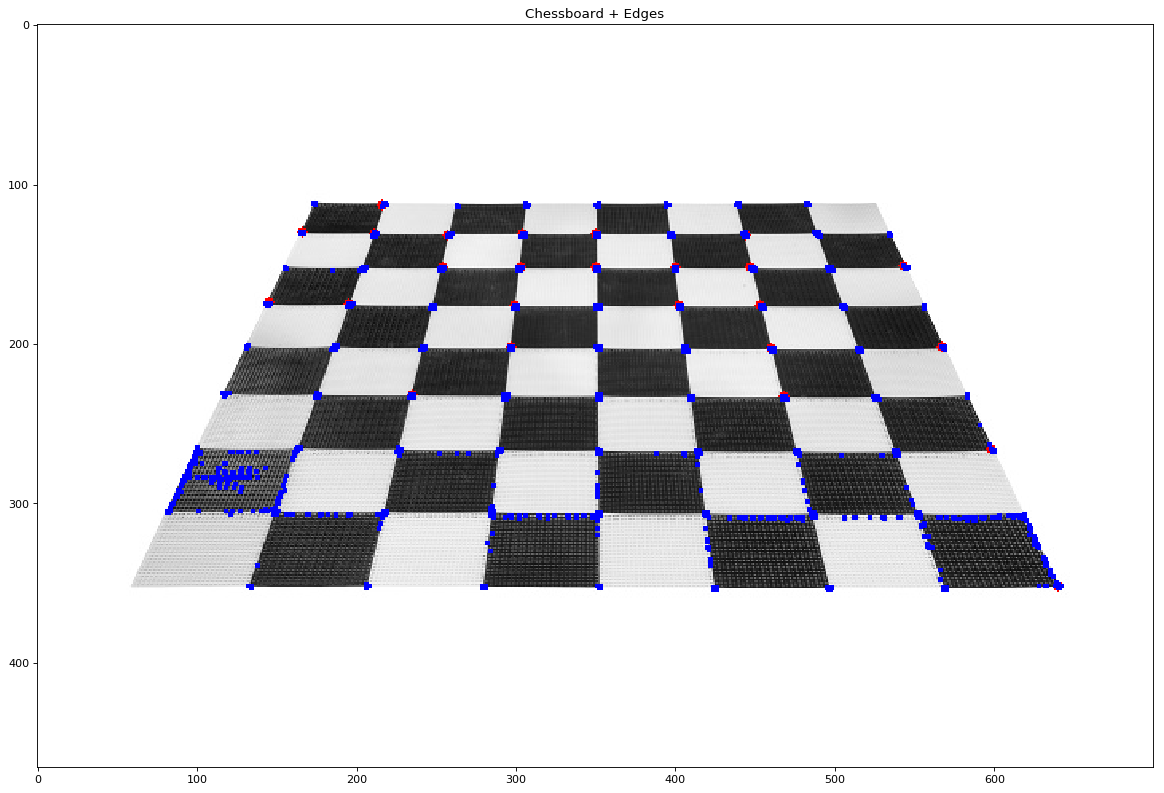

In [22]:
dst = cv2.cornerHarris(gray_f,2,3,0.04)
#result is dilated for marking the corners, not important
dst = cv2.dilate(dst,None)
# Threshold for an optimal value, it may vary depending on the image.
himg = img
himg[dst>0.01*dst.max()]=[0,0,255]
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(himg)
plt.title('Chessboard + Edges')
plt.show()

## Shi-Tomasi

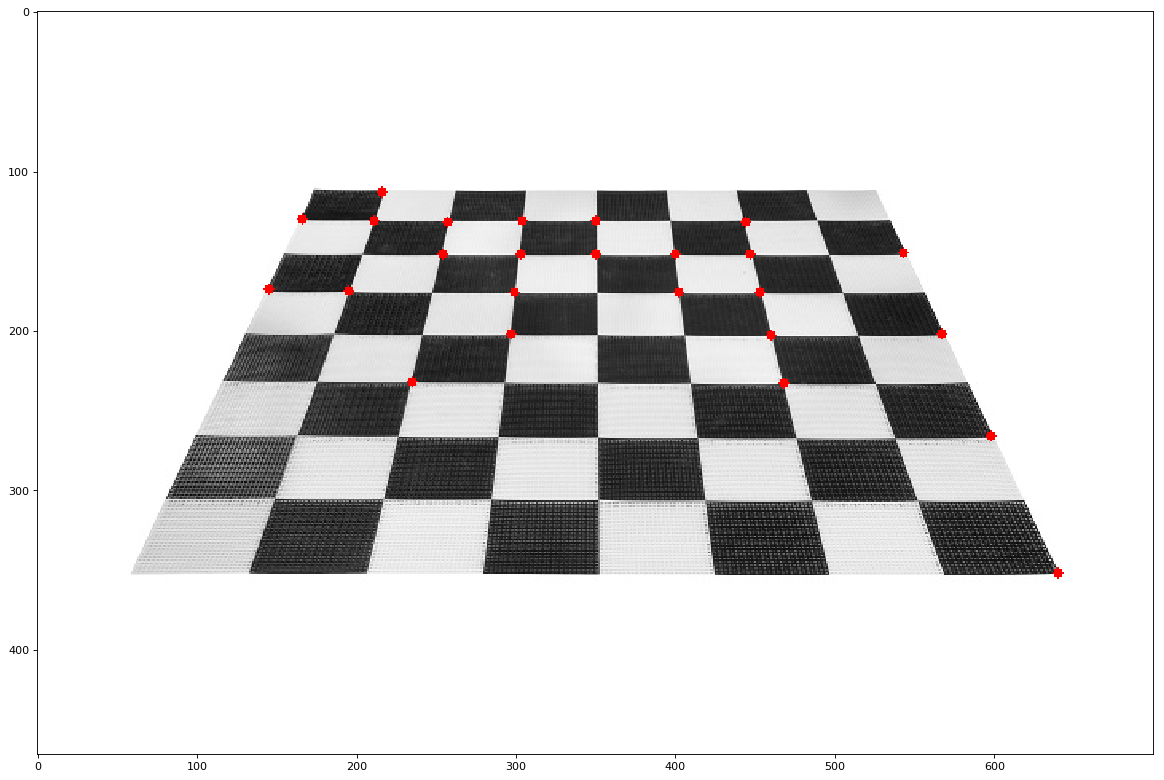

(<matplotlib.image.AxesImage at 0x7f44cf5c6240>, None)

In [27]:
corners = cv2.goodFeaturesToTrack(gray_f,25,0.01,10)
corners = np.int0(corners)
simg = img
for i in corners:
    x,y = i.ravel()
    cv2.circle(simg,(x,y),3,255,-1)
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(simg),plt.show()

## Sift

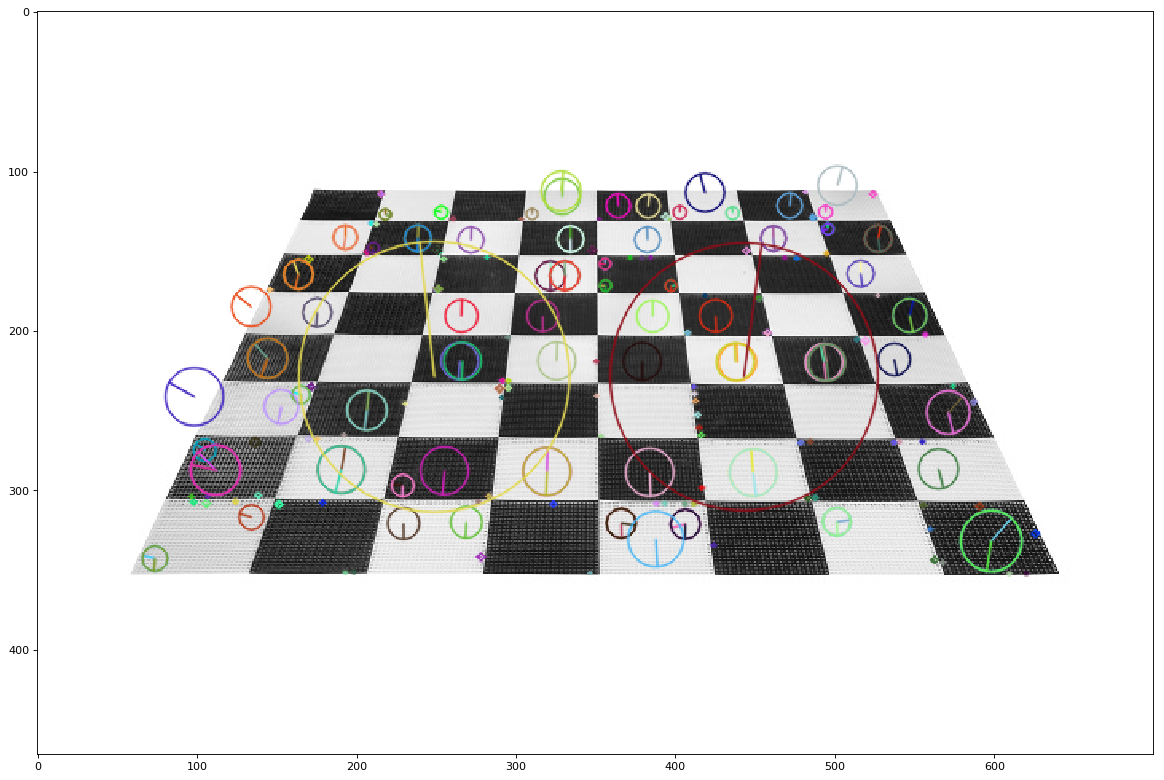

In [2]:
sift = cv2.xfeatures2d.SIFT_create()
kp, des = sift.detectAndCompute(gray,None)
siftimg = img
siftimg=cv2.drawKeypoints(gray,kp,img,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(siftimg)
plt.show()

## Feature matching
Brute force using ORB

In [2]:
img1 = cv2.imread('box.png',0)          # queryImage
img2 = cv2.imread('box_in_scene.png',0) # trainImage
# Initiate ORB detector
orb = cv2.ORB_create()
# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

In [3]:
# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
# Match descriptors.
matches = bf.match(des1,des2)
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

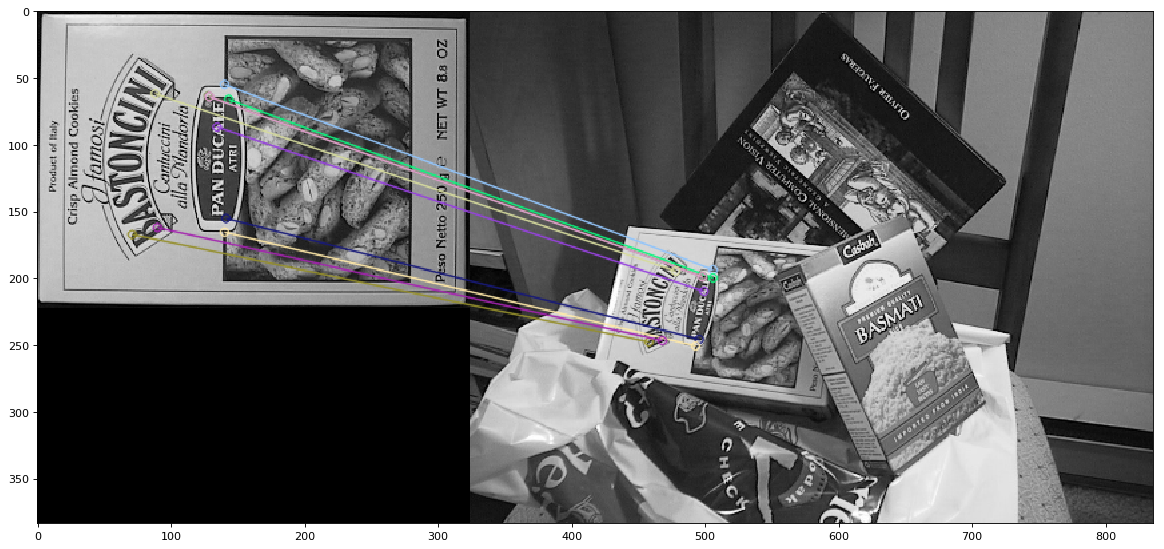

(<matplotlib.image.AxesImage at 0x7f00302b1e80>, None)

In [16]:
# Draw first 10 matches.
img3 = img2
img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches[:10], img3, flags=2)
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(img3),plt.show()

## Feature Matching + Homography to find Objects

In [22]:
MIN_MATCH_COUNT = 10
# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.match(des1,des2)
# store all the good matches as per Lowe's ratio test.

good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

error: /home/travis/miniconda/conda-bld/conda_1486587069159/work/opencv-3.1.0/modules/python/src2/cv2.cpp:163: error: (-215) The data should normally be NULL! in function allocate


In [18]:
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    h,w,d = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)
    img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

Not enough matches are found - 0/10


In [19]:
len(good)

0